# 内容
- データ読み込み
- split
- x, y生成
- 学習
- 評価
- submit

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

import utils as ut

## 準備

In [2]:
DEBUG = True
ut.seed_everything(24)

In [3]:
tr_file = "../../input/ventilator-pressure-prediction/train.csv"
ts_file = "../../input/ventilator-pressure-prediction/test.csv"
tr_df = pd.read_csv(tr_file)
ts_df = pd.read_csv(ts_file)

In [4]:
# shuffled breath_id
tr_df["shuffled_breath_id"] = ut.make_shuffled_id(tr_df["breath_id"])

## 学習

In [5]:
def make_x(df):
    ft = ut.Feature()
    x = ft.transform(df)
    return x

def make_y(df):
    tg = ut.Target()
    y = tg.transform(df)
    return y

def get_model(n_feat, prefix=""):
    model_prms = {
        "scaling_prms": dict(n_scaler=n_feat),
        "dnn_prms": dict(n_feat=n_feat, n_channel=256, dropout=0.0, n_rc_layer=4), 
        "tr_prms": dict(
            criterion=ut.VentilatorLoss(),
            opt="adamw",
            opt_params=dict(lr=0.001, weight_decay=1e-6),
            sch_params=None, #{'max_lr': lr, 'pct_start':0.1, 'div_factor':5, 'final_div_factor': 10000}, # initial_lr = max_lr/div_factor, min_lr = initial_lr/final_div_factor
            epochs=20, 
            prefix=prefix,
            save_best=True,
            maximize_score=False,
        ), 
        "seq_len": 80,
        "use_seq_len": 40, 
        "train_batch_size": 256,
        "pred_batch_size": 1024,
    }
    model = ut.Model(**model_prms)
    return model

def run_fold(tr_df, vl_df, prefix=""):
    # x, y
    tr_x = make_x(tr_df)
    tr_y = make_y(tr_df)
    vl_x = make_x(vl_df)
    vl_y = make_y(vl_df)

    model = get_model(tr_x.shape[1], prefix)
    model.fit(tr_x, tr_y, vl_x, vl_y)

    #tr_pred = model.predict(tr_x)
    vl_pred = model.predict(vl_x)

    #tr_df = pd.concat([tr_df, tr_x, pd.DataFrame(tr_pred, index=tr_df.index, columns=["pred"])], axis=1)
    vl_df = pd.concat([vl_df, vl_x, pd.DataFrame(vl_pred, index=vl_df.index, columns=["pred"])], axis=1)
    return model, tr_df, vl_df

def run_cv(df, n_split, n_fold):
    kf = model_selection.GroupKFold(n_splits=n_split)

    oof_df = []
    for fold, (tr_idxs, vl_idxs) in enumerate(kf.split(X=np.arange(len(df)), groups=df["shuffled_breath_id"].values)):
        if n_fold <= fold:
            break
        print("fold", fold)
        prefix = f"fold{fold}_"

        tr_df = df.iloc[tr_idxs].copy()
        vl_df = df.iloc[vl_idxs].copy()
        tr_df["fold"] = fold
        vl_df["fold"] = fold

        model, tr_df, vl_df = run_fold(tr_df, vl_df, prefix)

        oof_df.append(vl_df)
        with open(f'{prefix}model.pickle', mode='wb') as fp:
            model.set_dev('cpu')
            pickle.dump(model, fp)

        #tr_df.to_csv(f"{prefix}tr_df.csv", index=False)
        #vl_df.to_csv(f"{prefix}vl_df.csv", index=False)
    oof_df = pd.concat(oof_df, axis=0)

    return oof_df

In [6]:
n_split = 2
n_fold = 1
oof_df = run_cv(tr_df, n_split, n_fold)
oof_df.to_csv("oof.csv")

fold 0


  0%|          | 0/147 [00:00<?, ?it/s]


epoch  0
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.1810 | Score: 0.18100
{'loss': 0.1810031884989771, 'score': 0.18100323, 'mae': 0.18100323}
Valid Loss: 0.1280 | Score: 0.12804
{'loss': 0.1280245952106811, 'score': 0.1280394, 'mae': 0.1280394}
Update best score : 0.1280394
Save model : fold0_model.pth

epoch  1
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.1060 | Score: 0.10597
{'loss': 0.10597263372877017, 'score': 0.105972625, 'mae': 0.105972625}
Valid Loss: 0.0921 | Score: 0.09209
{'loss': 0.09208009532980017, 'score': 0.09208571, 'mae': 0.09208571}
Update best score : 0.09208571
Save model : fold0_model.pth

epoch  2
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0897 | Score: 0.08965
{'loss': 0.08965253302840148, 'score': 0.08965253, 'mae': 0.08965253}
Valid Loss: 0.0852 | Score: 0.08518
{'loss': 0.08516890273706333, 'score': 0.085180394, 'mae': 0.085180394}
Update best score : 0.085180394
Save model : fold0_model.pth

epoch  3
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0790 | Score: 0.07903
{'loss': 0.0790338486838503, 'score': 0.079033844, 'mae': 0.079033844}
Valid Loss: 0.0756 | Score: 0.07562
{'loss': 0.07561319482487601, 'score': 0.07562132, 'mae': 0.07562132}
Update best score : 0.07562132
Save model : fold0_model.pth

epoch  4
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0688 | Score: 0.06882
{'loss': 0.06882259457492504, 'score': 0.06882264, 'mae': 0.06882264}
Valid Loss: 0.0689 | Score: 0.06895
{'loss': 0.06893813569803496, 'score': 0.06894667, 'mae': 0.06894667}
Update best score : 0.06894667
Save model : fold0_model.pth

epoch  5
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0618 | Score: 0.06179
{'loss': 0.06179144134630962, 'score': 0.06179143, 'mae': 0.06179143}
Valid Loss: 0.0579 | Score: 0.05792
{'loss': 0.05791720435828776, 'score': 0.057918888, 'mae': 0.057918888}
Update best score : 0.057918888
Save model : fold0_model.pth

epoch  6
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0573 | Score: 0.05732
{'loss': 0.05732088467600394, 'score': 0.057320897, 'mae': 0.057320897}
Valid Loss: 0.0532 | Score: 0.05315
{'loss': 0.05315138087482066, 'score': 0.053154483, 'mae': 0.053154483}
Update best score : 0.053154483
Save model : fold0_model.pth

epoch  7
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0548 | Score: 0.05478
{'loss': 0.05478091185697082, 'score': 0.054780923, 'mae': 0.054780923}
Valid Loss: 0.0507 | Score: 0.05067
{'loss': 0.050663337916941255, 'score': 0.05066569, 'mae': 0.05066569}
Update best score : 0.05066569
Save model : fold0_model.pth

epoch  8
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0520 | Score: 0.05204
{'loss': 0.05203728349942739, 'score': 0.052037273, 'mae': 0.052037273}
Valid Loss: 0.0499 | Score: 0.04986
{'loss': 0.04985602884679227, 'score': 0.04985805, 'mae': 0.04985805}
Update best score : 0.04985805
Save model : fold0_model.pth

epoch  9
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0483 | Score: 0.04830
{'loss': 0.048298475414920015, 'score': 0.048298474, 'mae': 0.048298474}
Valid Loss: 0.0442 | Score: 0.04419
{'loss': 0.0441853992036871, 'score': 0.044186987, 'mae': 0.044186987}
Update best score : 0.044186987
Save model : fold0_model.pth

epoch  10
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 13.94it/s]


Train Loss: 0.0465 | Score: 0.04652
{'loss': 0.04651826450309786, 'score': 0.046518262, 'mae': 0.046518262}
Valid Loss: 0.0472 | Score: 0.04720
{'loss': 0.047196393379488506, 'score': 0.047195893, 'mae': 0.047195893}

epoch  11
lr  0.001


  1%|▏         | 2/147 [00:00<00:11, 12.65it/s]


Train Loss: 0.0450 | Score: 0.04501
{'loss': 0.0450052552077235, 'score': 0.045005243, 'mae': 0.045005243}
Valid Loss: 0.0447 | Score: 0.04468
{'loss': 0.044677341709265836, 'score': 0.044677544, 'mae': 0.044677544}

epoch  12
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.38it/s]


Train Loss: 0.0430 | Score: 0.04298
{'loss': 0.04297890463451139, 'score': 0.04297889, 'mae': 0.04297889}
Valid Loss: 0.0411 | Score: 0.04112
{'loss': 0.04112374248939592, 'score': 0.041124277, 'mae': 0.041124277}
Update best score : 0.041124277
Save model : fold0_model.pth

epoch  13
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.41it/s]


Train Loss: 0.0425 | Score: 0.04245
{'loss': 0.04245017076126572, 'score': 0.042450175, 'mae': 0.042450175}
Valid Loss: 0.0431 | Score: 0.04312
{'loss': 0.04312152788043022, 'score': 0.043124393, 'mae': 0.043124393}

epoch  14
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 13.28it/s]


Train Loss: 0.0411 | Score: 0.04115
{'loss': 0.041149422627728, 'score': 0.04114942, 'mae': 0.04114942}
Valid Loss: 0.0419 | Score: 0.04187
{'loss': 0.0418708767439868, 'score': 0.041870464, 'mae': 0.041870464}

epoch  15
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 13.19it/s]


Train Loss: 0.0404 | Score: 0.04042
{'loss': 0.04042157191200321, 'score': 0.04042157, 'mae': 0.04042157}
Valid Loss: 0.0388 | Score: 0.03885
{'loss': 0.038844486245432415, 'score': 0.038848586, 'mae': 0.038848586}
Update best score : 0.038848586
Save model : fold0_model.pth

epoch  16
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0394 | Score: 0.03944
{'loss': 0.03944328774501677, 'score': 0.03944328, 'mae': 0.03944328}
Valid Loss: 0.0377 | Score: 0.03772
{'loss': 0.037720829852529475, 'score': 0.03771986, 'mae': 0.03771986}
Update best score : 0.03771986
Save model : fold0_model.pth

epoch  17
lr  0.001


  1%|▏         | 2/147 [00:00<00:10, 14.11it/s]


Train Loss: 0.0379 | Score: 0.03790
{'loss': 0.03790212128640843, 'score': 0.03790212, 'mae': 0.03790212}
Valid Loss: 0.0376 | Score: 0.03757
{'loss': 0.037563990902256324, 'score': 0.037566353, 'mae': 0.037566353}
Update best score : 0.037566353
Save model : fold0_model.pth

epoch  18
lr  0.001


  0%|          | 0/147 [00:00<?, ?it/s]


Train Loss: 0.0375 | Score: 0.03746
{'loss': 0.037456003556243414, 'score': 0.037455995, 'mae': 0.037455995}
Valid Loss: 0.0374 | Score: 0.03739
{'loss': 0.03739474149974617, 'score': 0.037393052, 'mae': 0.037393052}
Update best score : 0.037393052
Save model : fold0_model.pth

epoch  19
lr  0.001


100%|██████████| 37/37 [00:03<00:00, 11.93it/s]



Train Loss: 0.0368 | Score: 0.03683
{'loss': 0.036831561805439644, 'score': 0.03683157, 'mae': 0.03683157}
Valid Loss: 0.0360 | Score: 0.03600
{'loss': 0.03599803018811587, 'score': 0.036000915, 'mae': 0.036000915}
Update best score : 0.036000915
Save model : fold0_model.pth


100%|██████████| 37/37 [00:02<00:00, 13.45it/s]


## 評価

In [7]:
ev = ut.Evaluation(oof_df)

In [8]:
score = ev.calc_scores()
print(score)

{0: {'mae': 0.5340834655627767}, 'av': {'mae': 0.5340834655627767}}


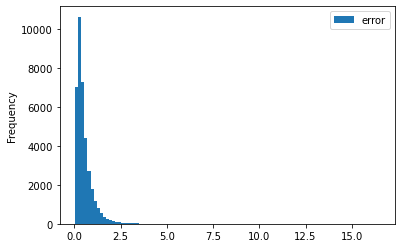

In [9]:
breath_mae = ev.calc_breath_mae()
breath_mae = breath_mae.sort_values("error", ascending=False)
breath_mae.plot.hist(bins=100)
plt.show()

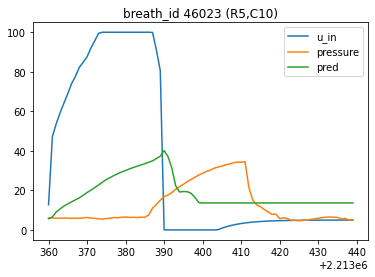

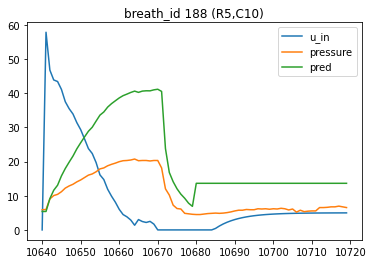

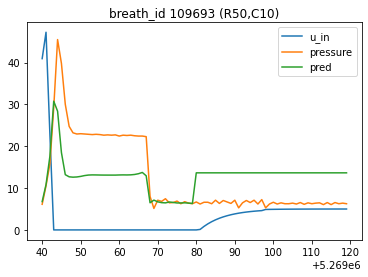

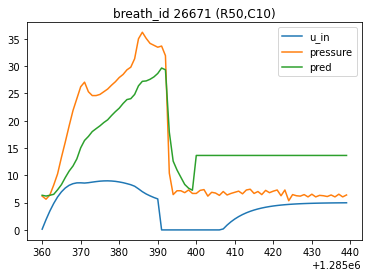

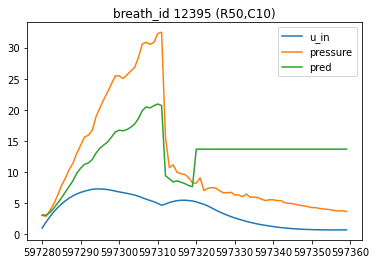

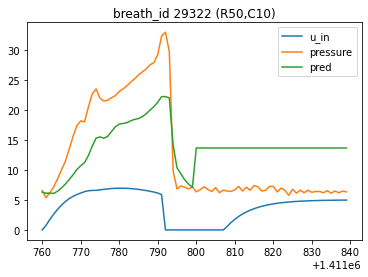

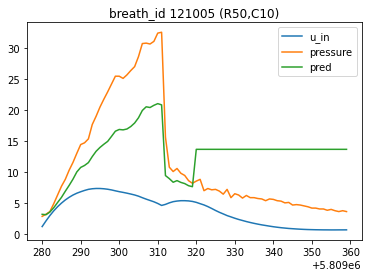

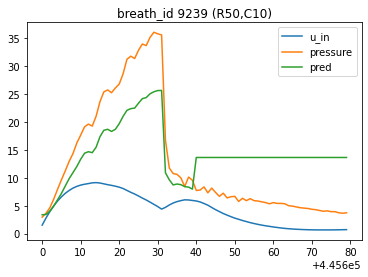

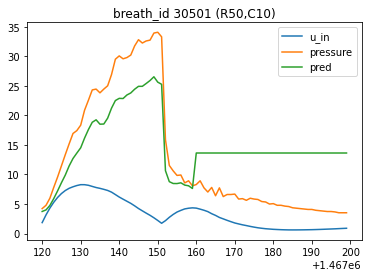

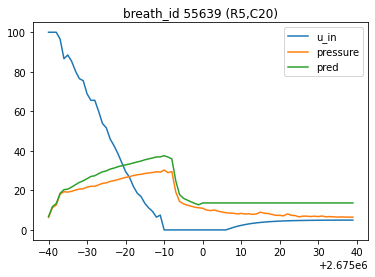

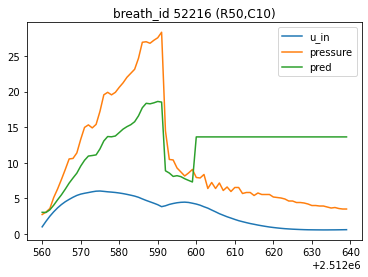

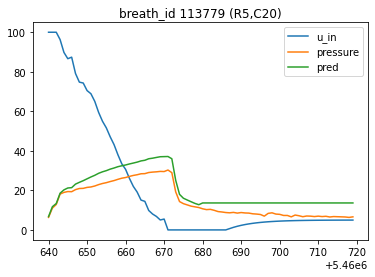

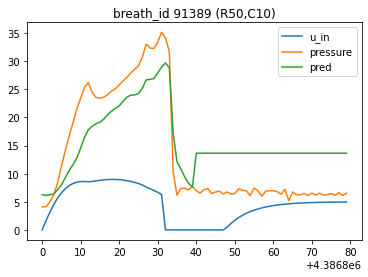

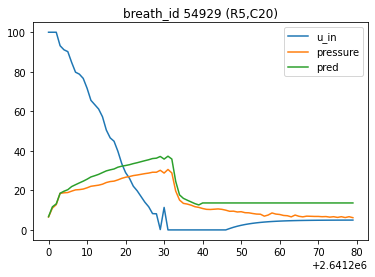

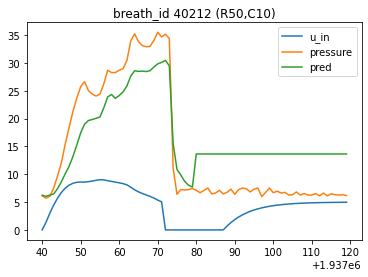

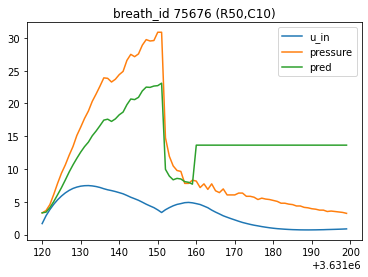

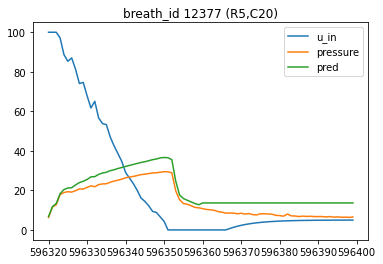

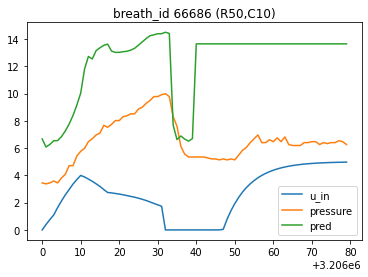

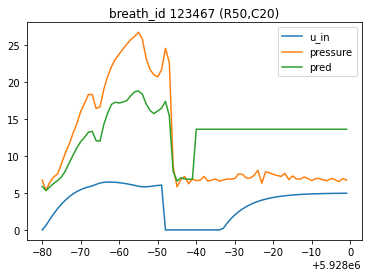

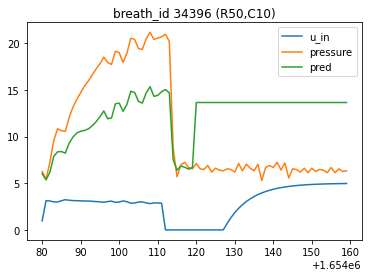

In [10]:
n_plot = 20
for i in range(n_plot):
    ev.plot_breath(breath_mae.index[i])

## 推論

In [11]:
def run_predict(model, df):
    x = make_x(df)
    pred = model.predict(x)
    return pred    

In [12]:
model = []
for fold in range(n_fold):
    with open(f"fold{fold}_model.pickle", 'rb') as p:
        mdl = pickle.load(p)
    model.append(mdl)

model = ut.EnsembleModel(model)

In [13]:
pred = run_predict(model, ts_df)
sub_df = ts_df[["id"]].copy()
sub_df["pressure"] = pred
sub_df.to_csv(f"submission_{os.path.basename(os.getcwd())}.csv", index=False)

 46%|████▌     | 23/50 [00:53<01:06,  2.47s/it]